# CREATING DOCUMENTATION

## PREPARING THE ENVIRONMENT

Importing the libraries:

In [1]:
import sys

sys.path.append('../')

In [2]:
import cv2
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from keras.models import load_model

from cv import preprocess,          \
               biggest_contour,     \
               get_perspective,     \
               split_cells,         \
               get_grid,            \
               SHAPE
from sudoku.utils import objective_grid,      \
                         first_available_pos, \
                         available_nums

Defining constants:

In [3]:
FONT = cv2.FONT_HERSHEY_SIMPLEX

## EFFICACY IN READING THE GRID

Displaying the number of errors in identifying sudoku cells as a function of the number of clues:

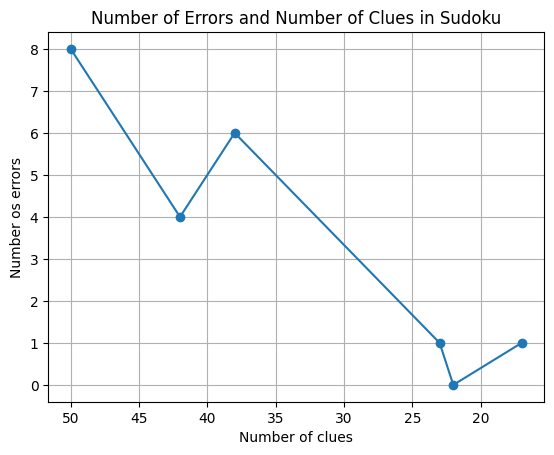

In [4]:
data = np.array([[50, 8],
                 [42, 4],
                 [38, 6],
                 [23, 1],
                 [22, 0],
                 [17, 1]])

x = data[:, 0]
y = data[:, 1]

plt.figure()

plt.plot(x, y, marker='o')
plt.gca().invert_xaxis()
plt.grid(True)

plt.title ('Number of Errors and Number of Clues in Sudoku')
plt.xlabel('Number of clues')
plt.ylabel('Number os errors')

plt.savefig('../docs/sudoku_ocr_errors.png')
plt.show()

## DEPTH-FIRST SEARCH WITH BACKTRACKING

Creating a video showing depth-first search with backtracking:

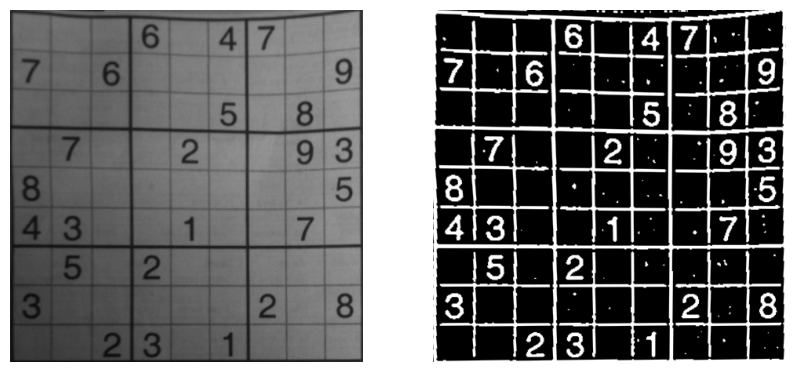

In [5]:
file_path  = '..\\examples\\sudoku_test.png'
model_path = '..\\models\\digits.keras'

image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
model = load_model(model_path)

processed = preprocess(image)
contour   = biggest_contour(processed)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, SHAPE)
image_sudoku = get_perspective(image, SHAPE, contour)
grid_sudoku  = get_perspective(processed, SHAPE, contour)

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.imshow(image_sudoku, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(grid_sudoku, cmap='gray')
plt.axis('off')

plt.show()

In [6]:
cells  = split_cells(grid_sudoku)
sudoku = get_grid(cells, model)

sudoku

array([[0, 0, 0, 6, 0, 4, 7, 0, 0],
       [7, 0, 6, 0, 0, 0, 0, 0, 9],
       [0, 0, 0, 0, 0, 5, 0, 8, 0],
       [0, 7, 0, 0, 2, 0, 0, 9, 3],
       [8, 0, 0, 0, 0, 0, 0, 0, 5],
       [4, 3, 0, 0, 1, 0, 0, 7, 0],
       [0, 5, 0, 2, 0, 0, 0, 0, 0],
       [3, 0, 0, 0, 0, 0, 2, 0, 8],
       [0, 0, 2, 3, 0, 1, 0, 0, 0]], dtype=uint8)

In [7]:
grid = sudoku.copy()
step = np.count_nonzero(grid == 0)

moves = [None] * step
actns = [None] * step

i    = 0
size = 0
while not objective_grid(grid) and i < 300:
    move = first_available_pos(grid)
    nums = available_nums(grid, move[1], move[0])

    if nums:
        grid [move] = nums.pop()
        moves[size] = move
        actns[size] = nums
        size += 1
    else:
        size -= 1

        while not actns[size]:
            if size == 0:
                break

            grid[moves[size]] = 0
            size -= 1

        move = moves[size]
        num  = actns[size].pop()

        grid[move] = num
        size += 1

    image_copy = image_sudoku.copy()
    for grd, ans, cell in zip(sudoku.flatten(),
                              grid.flatten()  ,
                              split_cells(image_copy)):
        if not grd and ans:
            cv2.putText(cell, str(ans), (10, 40), FONT,
                        1, (0, 0, 255), 2, cv2.LINE_AA)

    plt.figure(figsize=(8, 6))
    plt.imshow(image_copy)
    plt.axis('off')
    plt.savefig(f'../docs/docs_search/search_{i}.png', transparent=True)
    plt.close()

    i += 1

In [8]:
args_input  = '../docs/docs_search/*'
args_output = '../docs/search.mp4'
args_fps    = 4

files = glob.glob(args_input)
filename = Path(args_output).name
height, width, _ = cv2.imread(files[0]).shape

fourc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter(filename=filename, fourcc=fourc,
                        fps=args_fps, frameSize=(width, height))

for image in files:
    video.write(cv2.imread(image))

cv2.destroyAllWindows()
video.release()
shutil.move(filename, args_output)

'../docs/search.mp4'